<a href="https://colab.research.google.com/github/Elisa1999/CS542/blob/main/pset4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Set 4 
# Support Vector Machines

In this problem set you will implement an SVM and fit it using quadratic programming. We will use the CVXOPT module to solve the optimization problems. 

### Quadratic Programming (QP)

The standard form of a QP can be formulated as 
$$
\begin{align}
\min_x\quad &\frac12 x^TPx + q^Tx\\
\text{subject to }\quad & Gx \preceq h\\
& Ax = b
\end{align}
$$
where $\preceq$ is an element-wise $\leq$.
CVXOPT solver finds an optimal solution $x^*$, given a set of matrices $P, q, G, h, A, b$.

FYI, you can read on the methods to solve quadratic programming problems [here](https://en.wikipedia.org/wiki/Quadratic_programming#Solution_methods).

## Problem 1 (10 points)

Design appropriate matrices to solve the following problem.
$$
\begin{align}
\min_x\quad &f(x)=x_1^2 + 4x_2^2-8x_1-16x_2\\
\text{subject to }\quad & x_1+x_2\leq 5\\
& x_1 \leq 3\\
& x_2 \geq 0
\end{align}
$$

You might need to run this command on the Anaconda terminal: 
#### pip install cvxopt

In [4]:
#pip install cvxopt

In [15]:
matrix([[1.,1.],[1.,0.],[0.,-1.]])

<2x3 matrix, tc='d'>

In [3]:
from cvxopt import matrix, solvers
# Turns off the printing of CVXOPT solution for the rest of the notebook
solvers.options['show_progress'] = False

P = 2 * matrix([[1., 0.], [0., 4.]])
#------------------------------------------------------------------------------------------
# Define q, G, h
# Hint: the x vector is 2x1
#raise NotImplementedError('Construct the appropriate matrices.')
q = matrix([-8.,-16.])
G = matrix([[1.,1.,0.],[1.,0., -1.]])
h = matrix([5.,3.,0.])
#------------------------------------------------------------------------------------------

sol = solvers.qp(P, q, G, h)
x1, x2 = sol['x']
print('Optimal x: ({:.8f}, {:.8f})'.format(x1, x2))

Optimal x: (2.99999993, 1.99927914)


Let's visualize the solution

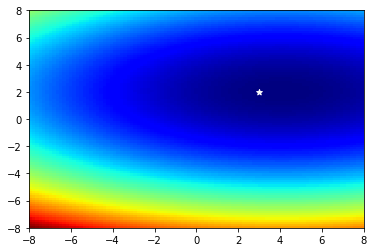

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

X1, X2 = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
F = X1**2 + 4*X2**2 - 8*X1 - 16 * X2

plt.pcolor(X1, X2, F, cmap='jet')
plt.scatter([x1], [x2], marker='*', color='white')
plt.show()

### Linear SVM

Now, let's implement linear SVM. We will do this for a general case, that allows class distributions to overlap.

As a linear model, linear SVM produces classification scores for a given sample $x$ as
$$
 \hat y(x) = w^T\phi(x) + b
$$
where $w\in\mathbb{R}^d$, $b\in\mathbb{R}$ are model weights and bias, respectively, and $\phi$ is a fixed feature-space transformation. Final label prediction is done by taking the sign of $\hat y(x)$.

Given a set of training samples $x_n\in\mathbb{R}^d$, $n\in 1,\ldots, N$, with the corresponding labels $y_i\in\{-1, 1\}$ linear SVM is fit (*i.e.* parameters $w$ and $b$ are chosen) by solving the following constrained optimization task:
$$
\begin{align}
    \min_{w, \xi, b}\quad & \frac12||w||^2 + C\sum_{n=1}^N \xi_n\\
    \text{subject to }\quad & y_n\hat y(x_n) \geq 1 - \xi_n, & n=1,\ldots, N\\
    & \xi_n \geq 0, & n=1,\ldots, N
\end{align}
$$

## Problem 2 (40 points)
## 2.1 [30 pts]
Your task is to implement this using a QP solver by designing appropriate matrices $P$, $q$, $G$, $h$.

##### Hints
1. You need to optimize over $w, \xi, b$. You can simply concatenate them into $\chi = (w, \xi, b)$ to feed it into QP-solver. Now, how to define the objective function and the constraints in terms of $\chi$? (For example, $b_1 + b_2$ can be obtained from vector $(a_1, b_1, b_2, c_1, c_2)$ by taking the inner product with $(0, 1, 1, 0, 0)$).
3. You can use `np.bmat` to construct matrices. Like this:

In [197]:
np.bmat([[np.identity(3), np.zeros((3, 1))],
         [np.zeros((2, 3)), -np.ones((2, 1))]])

matrix([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.]])

In [263]:
from sklearn.base import BaseEstimator

class LinearSVM(BaseEstimator):
    def __init__(self, C, transform=None):
        self.C = C
        self.transform = transform
        
    def fit(self, X, Y):
        """Fit Linear SVM using training dataset (X, Y).
        
        :param X: data samples of shape (N, d).
        :param Y: data target labels of size (N). Each label is either 1 or -1.
        """
        # Apply transformation (phi) to X
        if self.transform is not None:
            X = self.transform(X)
        d = len(X[0])
        N = len(X)
        
        
        #------------------------------------------------------------------------------------------
        # Construct appropriate matrices here to solve the optimization problem described above.
        # We want optimal solution for vector (w, xi, b). 
        #raise NotImplementedError('Construct the appropriate matrices.')
        P = matrix(np.bmat([[np.identity((d)), np.zeros((d, N+1))], [np.zeros((N+1, d+N+1))]])) #w xi b
        q = matrix([0.] * d + [self.C] * N + [0.])
        G = matrix(np.bmat([[(-Y*np.identity((N))).dot(X), -np.identity((N)), np.transpose(-Y * np.ones((1,N)))],
                     [np.zeros((N,d)), -np.identity(N), np.zeros((N,1))]])) #w xi b
        h = matrix([-1]*N + [0.]*N)
        #------------------------------------------------------------------------------------------
        
        sol = solvers.qp(P, q, G, h)
        ans = np.array(sol['x']).flatten()
        self.weights_ = ans[:d]
        self.xi_ = ans[d:d+N]
        self.bias_ = ans[-1]
        
        # Find support vectors. A boolean array of length N having True for support
        # vectors and False for the rest.
        margin = Y * (X.dot(model.weights_) + self.bias_)
        self.support_vectors = np.isclose(margin,  1 - self.xi_)
        
    def predict_proba(self, X):
        """
        Make real-valued prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N predicted scores.
        """
        #------------------------------------------------------------------------------------------
        if self.transform is not None:
            X = self.transform(X)
        return X.dot(self.weights_) + self.bias_
        #raise NotImplementedError('Return y_hat.')
        #------------------------------------------------------------------------------------------

    def predict(self, X):
        """
        Make binary prediction for some new data.
        :param X: data samples of shape (N, d).
        :return: an array of N binary predicted labels from {-1, 1}.
        """
        return np.sign(self.predict_proba(X))

Let's see how our LinearSVM performs on some data.

In [264]:
from sklearn.datasets import make_classification, make_circles
X = [None, None, None]
y = [None, None, None]
X[0], y[0] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=1)
X[1], y[1] = make_circles(n_samples=100, factor=0.5)
X[2], y[2] = make_classification(n_samples=100, n_features=2, n_redundant=0, n_clusters_per_class=1, random_state=4)

# Go from {0, 1} to {-1, 1}
y = [2 * yy - 1 for yy in y]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: No contour levels were found within the data range.


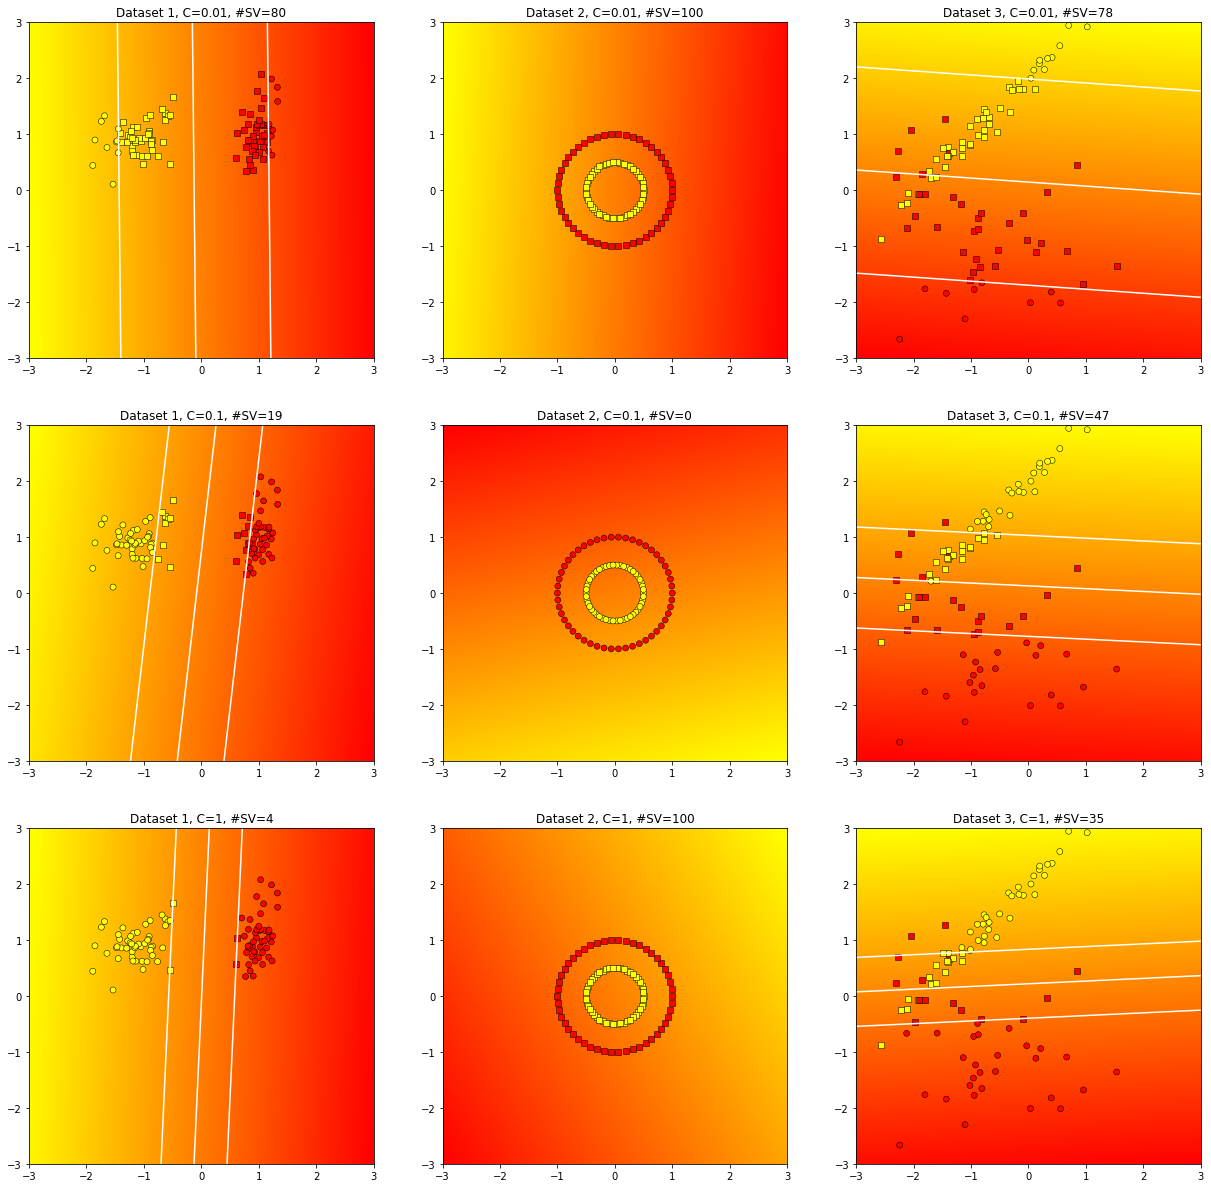

In [265]:
C_values = [0.01, 0.1, 1]

plot_i = 0
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Why does the number of support vectors decrease as $C$ increases?

For debug purposes. Very last model must have almost the same weights and bias:
$$w = \begin{pmatrix}-0.0784521\\ 1.62264867\end{pmatrix}$$
$$b = -0.3528510092782581$$

In [266]:
model.weights_

array([-0.0784521 ,  1.62264867])

In [267]:
model.bias_

-0.35285100927825813

## 2.2 [10 pts]

Even using a linear SVM, we are able to separate data that is linearly inseparable by using feature transformation.

Implement the following feature transformation
$
    \phi(x_1, x_2) = (x_1,\ x_2,\ x_1^2,\ x_2^2,\ x_1x_2)
$

In [268]:
def append_second_order(X):
    """Given array Nx[x1, x2] return Nx[x1, x2, x1^2, x2^2, x1x2]."""
    #------------------------------------------------------------------------------------------
    return np.concatenate((X, X * X, (X[:, :1] * X[:, 1:])), axis = 1)
    #raise NotImplementedError('Return new_X.')
    #------------------------------------------------------------------------------------------

assert np.all(append_second_order(np.array([[1, 2]])) == np.array([[1, 2, 1, 4, 2]])), 'Transformation is incorrect.'

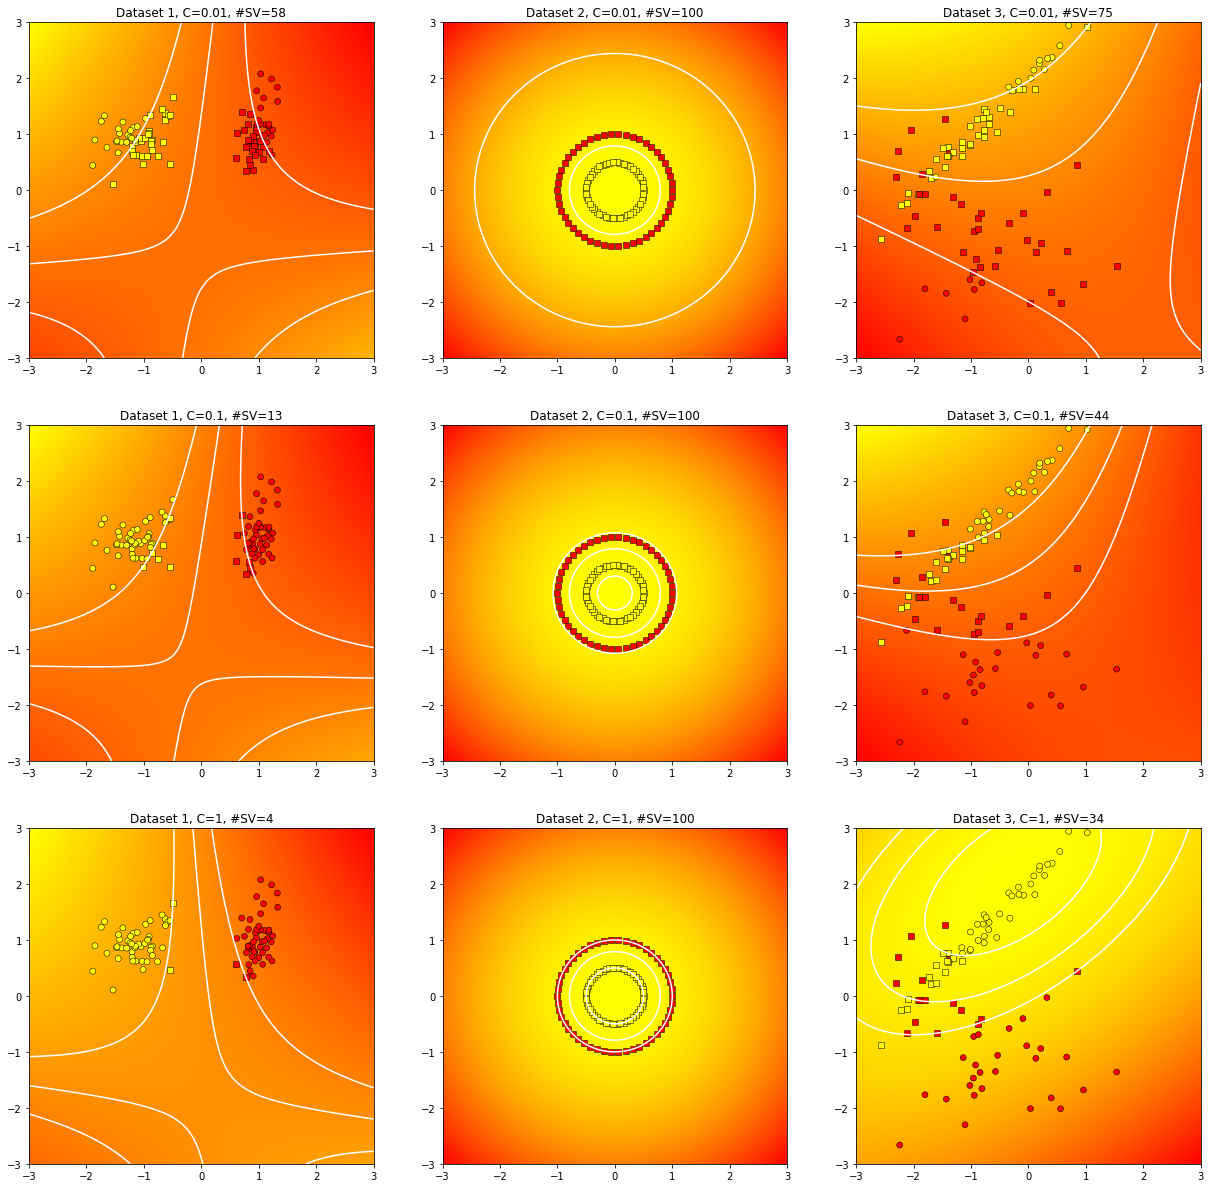

In [269]:
plot_i = 0
C_values = [0.01, 0.1, 1]
plt.figure(figsize=(len(X) * 7, len(C_values) * 7))
for C in C_values:
    for i in range(len(X)):
        plot_i += 1
        plt.subplot(len(C_values), len(X), plot_i)
        #----------------------------------------------------------------------------
        model = LinearSVM(C=C, transform=append_second_order)
        #----------------------------------------------------------------------------
        model.fit(X[i], y[i])
        sv = model.support_vectors
        n_sv = sv.sum()
        if n_sv > 0:
            plt.scatter(X[i][:, 0][sv], X[i][:, 1][sv], c=y[i][sv], cmap='autumn', marker='s',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        if n_sv < len(X[i]):
            plt.scatter(X[i][:, 0][~sv], X[i][:, 1][~sv], c=y[i][~sv], cmap='autumn',
                        linewidths=0.5, edgecolors=(0, 0, 0, 1))
        xvals = np.linspace(-3, 3, 200)
        yvals = np.linspace(-3, 3, 200)
        xx, yy = np.meshgrid(xvals, yvals)
        zz = np.reshape(model.predict_proba(np.c_[xx.ravel(), yy.ravel()]), xx.shape)
        plt.pcolormesh(xx, yy, zz, cmap='autumn', zorder=0)
        plt.contour(xx, yy, zz, levels=(-1, 0, 1,), colors='w', linewidths=1.5, zorder=1, linestyles='solid')

        plt.xlim([-3, 3])
        plt.ylim([-3, 3])
        plt.title('Dataset {}, C={}, #SV={}'.format(i + 1, C, n_sv))
plt.show()

Awesome! Have a look at SVM from scikit-learn module and how it is used. 

# Problem 3 Written Problems (20 points)

## 3.1 PCA [3 pts]
Suppose we are given inputs $𝑥^𝑖 \in ℝ^𝑛, 𝑖=1,…,𝑚$ and we want to learn a lower-dimensional ($k$-dim) PCA projection of the data onto basis vectors $𝑈=[𝑢^1…𝑢^𝑘]$ where each $𝑢^𝑗 \in ℝ^𝑛$.  Write down the equation for the general $k$-dimensional point $z^𝑖$ obtained by projecting an $n$-dimensional point  $𝑥^𝑖$ onto the $k$ basis vectors.

$$ Z_k =  U^T\bar{x}$$ where $\bar{x}$ is a normalized data point. 

## 3.2 CNNs [8 pts]

Draw a convolutional network with input $x \in R^4$, one hidden layer with 3x1 filters and 2 channels with stride 1, and a fully-connected output layer with one neuron. How many parameters does this network have? Include all biases.

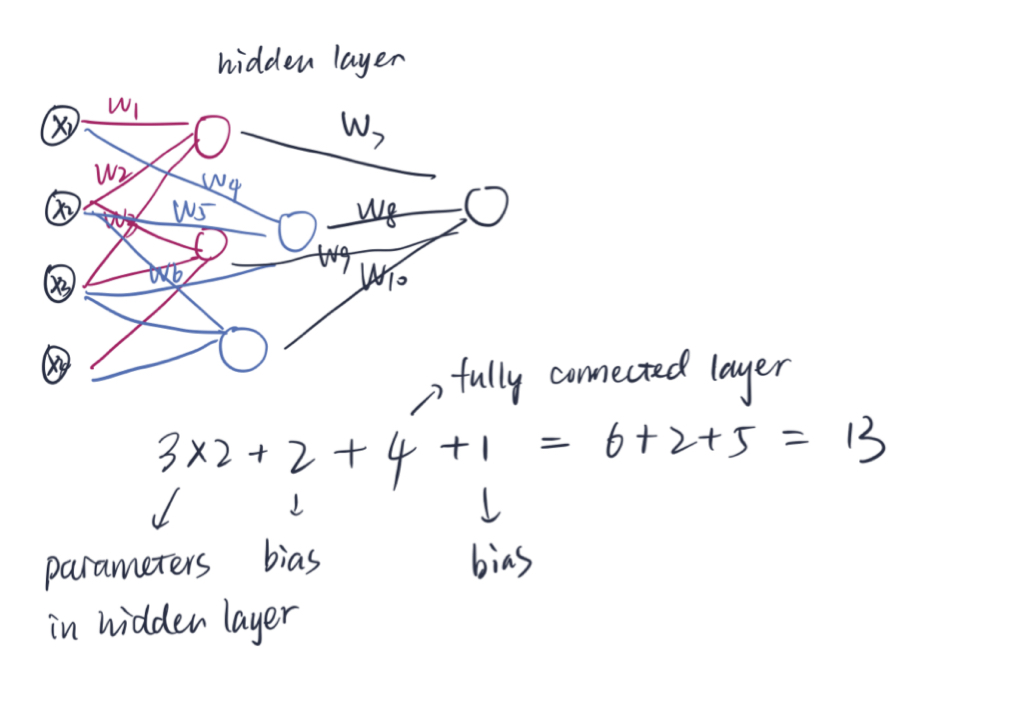

In [2]:
from IPython.display import Image 
Image('IMG_2D0C8D7E41F2-1.jpeg',width=500)


(3*2) + 2 + 5 = 13

## 3.3 Semi-supervised Learning [3 pts]
What is the difference between co-training and self-training in semi-supervised learning?

The main difference between co-training and self-training is the number of models we will train. In the self-training, we will train one model and use predictions that we have most confidence to update the model. In the co-training, we will seperate the features into two sets. And we assume that each subset of features is sufficient to train a good classifier. We will add predictions that we have most confidence in model 1 to model 2 and same for model 2. 

## 3.4 Explainability [3 pts]
What is the difference between black-box and white-box explainability techniques?

Black-box models have observable input-output relationships but lack clarity around inner workings. While, white-box models have observable/understandable behaviors, features, and relationships between influencing variables and the output predictions. Whilte-box models are usually have low accuracy but high explainability compared to black-box model.



## 3.5 Domain Adaptation [3 pts]
Assume you have data consisting of images of the road in the summer in which you have labeled road signs, and images of the road in the winter in which you have no labels for the road signs. Explain one way you could label the road signs in the images taken in winter with a decent accuracy.

We will use adversarial domain alignment. We first use CNN to train a classifier using our source data (images of the road in the summer) and we shared the parameters of the CNN with unlaeled target data (images of the road in the winter). Then we need a domain discriminator(GAN) to distinguish between source and target data using adversarial loss. The loss function will minimize the sum of the classification loss and adversarial loss.